# Instance Segmentation with Mask Region Based Convolutional Neural Network.

You should have seen in our previous posts that Convolutional Neural Network is the state of the art for any computer vision task like

- [Image classification](https://www.learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/)

- [Semantic Segmentation](https://www.learnopencv.com/pytorch-for-beginners-semantic-segmentation-using-torchvision/)

- [Object Detection](https://www.learnopencv.com/faster-r-cnn-object-detection-with-pytorch/)

In this notebook we will look at another computer vision application called Instance Segmentation. 

# Instance Segmentation
  Instance Segmentation is a combination of 2 problems
  - Object Detection
  - Semantic Segmentation
  
![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRmp4t9zSQ9DWyTuWv2OwK4Eq4ydaBbvl1FiaslP_y0etJ89n-5)
  
A kind of network called Mask RCNN is the state of the art in Instance Segmentation. Mask RCNN uses 2 type of networks one like Faster RCNN for Object Detection and another fully convolutional network for Semantic Segmentation. The first model will get the bounding box and classify it and the second model is used on each of the region of interest for semantic segmentation. 
  
![](https://cdn-images-1.medium.com/max/1600/1*IWWOPIYLqqF9i_gXPmBk3g.png)
Image Source: [Mask R-CNN](https://arxiv.org/pdf/1703.06870.pdf)

# Instance Segmentation in PyTorch

If you want to learn more about all of these models and many more application and concepts of Deep Learning and Computer Vision indetail,  check out the official [Deep Learning and Computer Vision courses](https://opencv.org/courses/) by OpenCV.org.

  All the pretrained models in pytorch can be found in [torchvision.models](https://pytorch.org/docs/stable/torchvision/models.html)



The input to the model is expected to be a list of tensors, each of shape [C, H, W], one for each image, and should be in 0-1 range. Different images can have different sizes.


During inference, the model requires only the input tensors, and returns the post-processed predictions as a List[Dict[Tensor]], one for each input image. The fields of the Dict are as follows:

- boxes (Tensor[N, 4]): the predicted boxes in [x0, y0, x1, y1] format, with values between 0 and H and 0 and W

- labels (Tensor[N]): the predicted labels for each image

-  scores (Tensor[N]): the scores or each prediction

-  masks (Tensor[N, H, W]): the predicted masks for each instance, in 0-1 range. In order to obtain the final segmentation masks, the soft masks can be thresholded, generally with a value of 0.5 (mask >= 0.5)

In [67]:
# import necessary libraries
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import torch
import numpy as np
import cv2
import random

# get the pretrained model from torchvision.models
# Note: pretrained=True will get the pretrained weights for the model.
# model.eval() to use the model for inference
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()


def random_colour_masks(image):
  """
  random_colour_masks
    parameters:
      - image - predicted masks
    method:
      - the masks of each predicted object is given random colour for visualization
  """
  colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
  coloured_mask = np.stack([r, g, b], axis=2)
  return coloured_mask

def get_prediction(img_path, threshold, objects):
  """
  get_prediction
    parameters:
      - img_path - path of the input image
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - masks, classes and bounding boxes are obtained from the model and soft masks are made binary(0 or 1) on masks
        ie: eg. segment of cat is made 1 and rest of the image is made 0
    
  """
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  pred = model([img])
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
  masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
  pred_class = [objects[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class


def instance_segmentation_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3, objects=COCO_INSTANCE_CATEGORY_NAMES):
  """
  instance_segmentation_api
    parameters:
      - img_path - path to input image
    method:
      - prediction is obtained by get_prediction
      - each mask is given random color
      - each mask is added to the image in the ration 1:0.8 with opencv
      - final output is displayed
  """
  masks, boxes, pred_cls = get_prediction(img_path, threshold, objects)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  for i in range(len(masks)):
    rgb_mask = random_colour_masks(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
    #cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # no bounding boxes required
    cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
  plt.figure(figsize=(20,30))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

* Obtain segmentation instance, apply style transfer to it (store as a mask), and superimpose that mask on top of the original image (excluding the background)

In [68]:
# Separating out the object names will be useful in object-specific filtering, but not instance segmentation
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

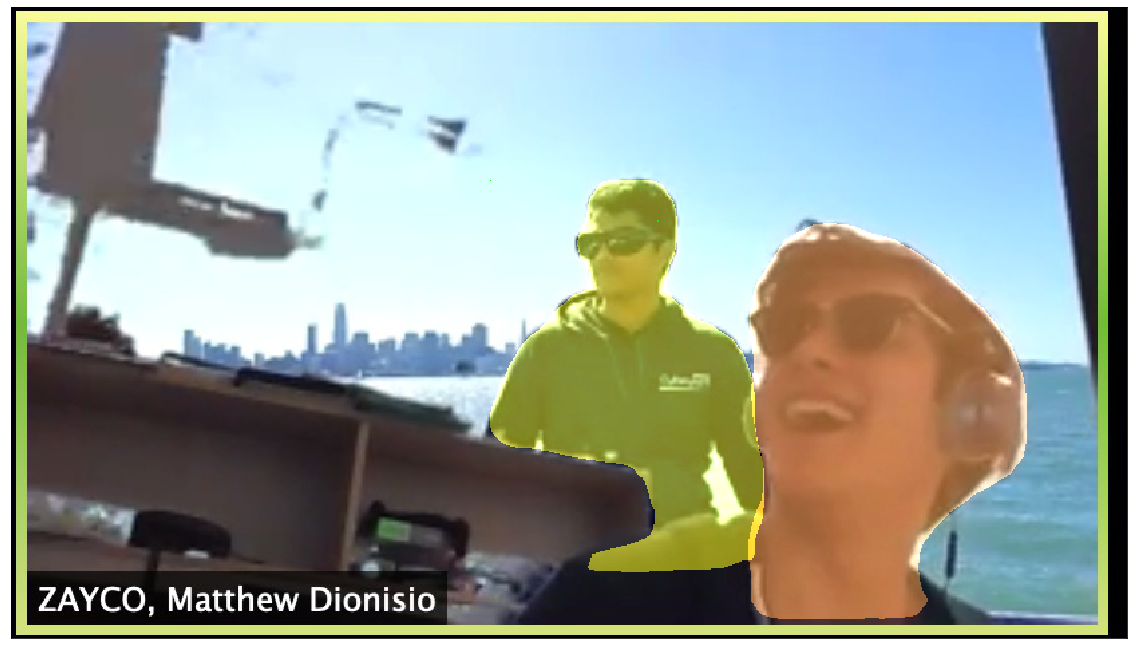

In [69]:
instance_segmentation_api(img_path='./payload/IMG-20200401-WA0002.jpg', threshold=0.75, rect_th=0, text_size=0, text_th=0, objects=COCO_INSTANCE_CATEGORY_NAMES)

## Example to understand how masks are added to the input image

In [47]:
colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]

a,b,c=colours[0]


In [160]:
img_original = Image.open('./payload/IMG-20200401-WA0002.jpg')
transform = T.Compose([T.ToTensor()])
img = transform(img_original)
pred = model([img])

In [155]:
# pred[0]['masks']>0.5
# (pred[0]['masks']>0.5).shape

segment = 0

(pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()[segment].shape

(472, 834)

In [119]:
img[0].shape

torch.Size([472, 834])

In [184]:
(pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()[segment]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

(472, 834)


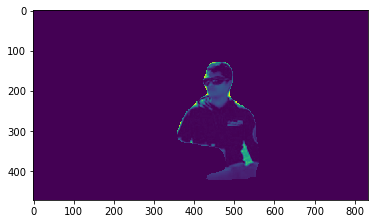

In [181]:
segment = 0
mask = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()[segment]

# print mask of image with the original image pixels
img_array = np.array(img[0])
# if False, set as 0 (black)
print(img_array.shape)
# img_array[img_array.shape[0]-1][img_array.shape[1]-1]

masked_img = []
for i in range(img_array.shape[0]):
    tmp=[]
    for j in range(img_array.shape[1]):
        if mask[i][j] == False:
            tmp.append(float(0))
        else:
            tmp.append(img_array[i][j])
    masked_img.append(tmp)
    
masked_img_array = np.array(masked_img)
plt.imshow(masked_img_array) # Export this mask image for style transfer
plt.show()

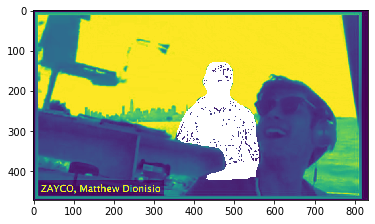

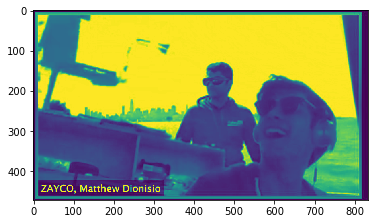

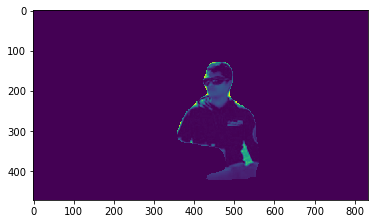

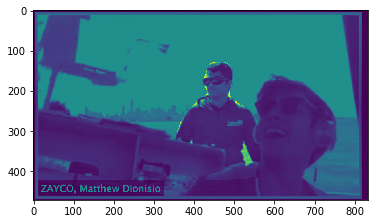

In [269]:
# combining two images on top of each other
import numpy.ma as ma
plt.imshow(combined_masks)
plt.show()
plt.imshow(img[2])
plt.show()
combined_masks = ma.masked_array(img[2], masked_img_array>0) # clears out pixels so that we can superimpose
masked_img = cv2.addWeighted(np.array(combined_masks, np.float64), 0, np.array(masked_img_array, np.float64), 0.5, 0)
plt.imshow(masked_img)
plt.show()
# split the image as 50% focus on masked_img_array, 50% on combined_masks
masked_img = cv2.addWeighted(np.array(masked_img_array, np.float64), 0.5, np.array(combined_masks, np.float64), 0.5, 0)
plt.imshow(masked_img)
plt.show()

In [243]:
masked_img_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [246]:
type(combined_masks)
type(masked_img_array)


array([0.        , 0.        , 0.        , 0.00784314, 0.02352941,
       0.03137255, 0.01568628, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01568628, 0.00392157, 0.00392157, 0.00392157, 0.00392157,
       0.00392157, 0.00392157, 0.00392157, 0.00784314, 0.00784314,
       0.00784314, 0.00784314, 0.00784314, 0.00784314, 0.00784314,
       0.00784314, 0.00784314, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00392157, 0.00392157,
       0.00392157, 0.00392157, 0.00392157, 0.00392157, 0.00392157,
       0.00392157, 0.00392157, 0.00392157, 0.00392157, 0.00392157,
       0.00392157, 0.00392157, 0.00392157, 0.00392157, 0.00392157,
       0.00392157, 0.00392157, 0.00392157, 0.00392157, 0.00392157,
       0.00392157, 0.00392157, 0.        , 0.        , 0.     

#### Can ignore stuff below, jsut for reference

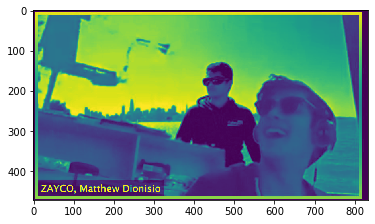

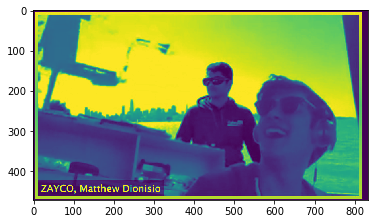

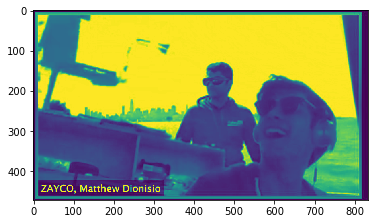

In [104]:
img[0]
plt.imshow(img[0])
plt.show()
plt.imshow(img[1])
plt.show()
plt.imshow(img[2])
plt.show()

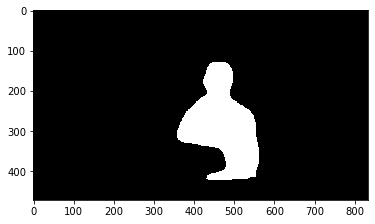

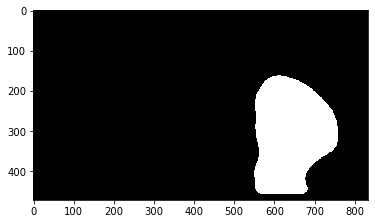

In [107]:
masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
masks.shape

plt.imshow(masks[0], cmap='gray')
plt.show()

plt.imshow(masks[1], cmap='gray') 
plt.show()

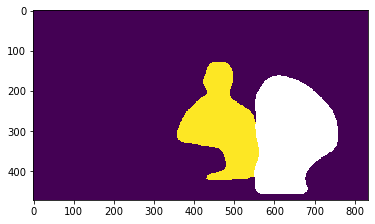

In [53]:
import numpy.ma as ma

combined_masks = ma.masked_array(masks[0] > 0, masks[1])
plt.imshow(combined_masks)
plt.show()

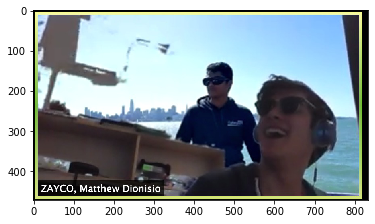

In [148]:
import matplotlib.image as mpimg
img=mpimg.imread('./payload/IMG-20200401-WA0002.jpg')
plt.imshow(img)
plt.show()

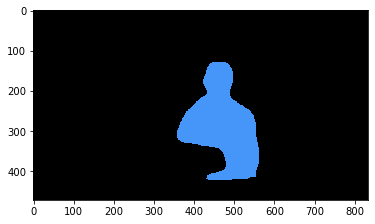

In [149]:
mask1 = random_colour_masks(masks[0])
mask2 = random_colour_masks(masks[1])
plt.imshow(mask1); plt.show()

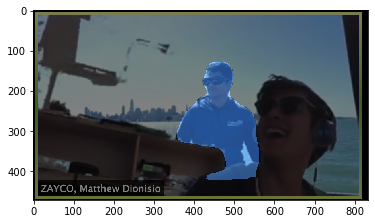

In [151]:
masked1 = cv2.addWeighted(img, 0.5, mask1, 0.5, 0)
masked2 = cv2.addWeighted(img, 0.5, mask2, 0.5, 0)

plt.imshow(masked1)

# Comparing the inference time of model in CPU & GPU



In [0]:
import time

def check_inference_time(image_path, gpu=False):
  model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
  model.eval()
  img = Image.open(image_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  if gpu:
    model.cuda()
    img = img.cuda()
  else:
    model.cpu()
    img = img.cpu()
  start_time = time.time()
  pred = model([img])
  end_time = time.time()
  return end_time-start_time

In [112]:
cpu_time = sum([check_inference_time('./mrcnn_people.jpg', gpu=False) for _ in range(5)])/5.0
gpu_time = sum([check_inference_time('./mrcnn_people.jpg', gpu=True) for _ in range(5)])/5.0


print('\n\nAverage Time take by the model with GPU = {}s\nAverage Time take by the model with CPU = {}s'.format(gpu_time, cpu_time))



Average Time take by the model with GPU = 0.5736178874969482s
Average Time take by the model with CPU = 10.966966199874879s
